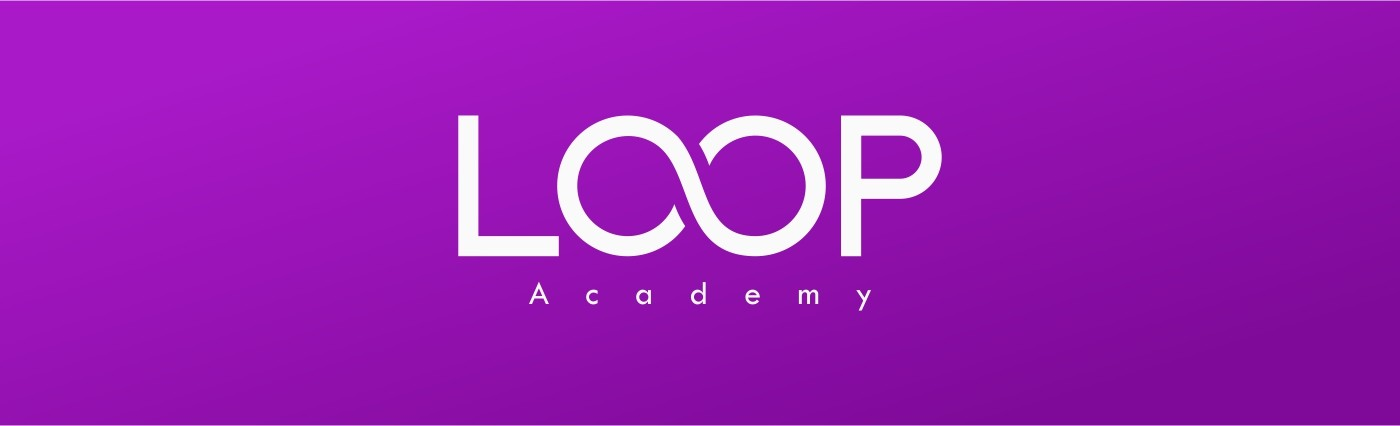

some part of this notebook are copied from Jose Marcial Portilla works.

# MNIST Code Along with CNN

## Perform standard imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F          # adds some efficiency
from torch.utils.data import DataLoader  # lets us load data in batches
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix  # for evaluating results
import matplotlib.pyplot as plt
%matplotlib inline

## Load the MNIST dataset
PyTorch makes the MNIST dataset available through <a href='https://pytorch.org/docs/stable/torchvision/index.html'><tt><strong>torchvision</strong></tt></a>. The first time it's called, the dataset will be downloaded onto your computer to the path specified. From that point, torchvision will always look for a local copy before attempting another download.
### Define transform
As part of the loading process, we can apply multiple transformations (reshape, convert to tensor, normalize, etc.) to the incoming data.<br>For this exercise we only need to convert images to tensors. 

In [2]:
transform = transforms.ToTensor()

### Load the training set

In [3]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

### Load the test set
There's a companion set of MNIST data containing 10,000 records accessible by setting train=False. As before, torchvision will only download this once, and in the future will look for the local copy.

In [4]:
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
datasets

<module 'torchvision.datasets' from '/usr/local/lib/python3.7/dist-packages/torchvision/datasets/__init__.py'>

In [6]:
type(test_data)

torchvision.datasets.mnist.MNIST

### Examine a training record

In [7]:
type(train_data[0])

tuple

In [8]:
len(train_data[0])

2

In [9]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [10]:
type(train_data[0][0])

torch.Tensor

In [11]:
train_data[0][0].size()

torch.Size([1, 28, 28])

Calling the first record from <tt>train_data</tt> returns a two-item tuple. The first item is our 28x28 tensor representing the image. The second is a label, in this case the number "5".

In [12]:
image, label = train_data[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([1, 28, 28]) 
Label: 5


### View the image
Matplotlib can interpret pixel values through a variety of <a href='https://matplotlib.org/tutorials/colors/colormaps.html'>colormaps</a>.

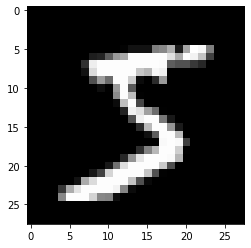

In [13]:
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gray");

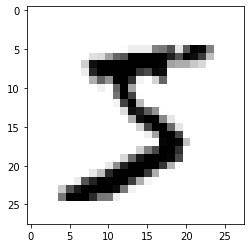

In [14]:
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gist_yarg");

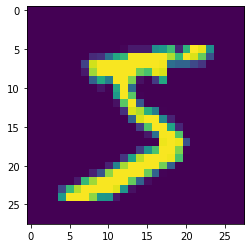

In [15]:
plt.imshow(train_data[0][0].reshape((28,28)));

## Batch loading with DataLoader
Our training set contains 60,000 records. If we look ahead to our model we have 784 incoming features, hidden layers of 120 and 84 neurons, and 10 output features. Including the bias terms for each layer, the total number of parameters being trained is:<br>

$\begin{split}\quad(784\times120)+120+(120\times84)+84+(84\times10)+10 &=\\
94080+120+10080+84+840+10 &= 105,214\end{split}$<br>

For this reason it makes sense to load training data in batches using <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'><tt><strong>DataLoader</strong></tt></a>.

In [16]:
torch.manual_seed(101)  # for consistent results

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)

test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In the cell above, <tt><strong>train_data</strong></tt> is a PyTorch <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset'><em>Dataset</em></a> object (an object that supports data loading and sampling).<br>
The <tt><strong>batch_size</strong></tt> is the number of records to be processed at a time. If it's not evenly divisible into the dataset, then the final batch contains the remainder.<br>
Setting <tt><strong>shuffle</strong></tt> to True means that the dataset will be shuffled after each epoch.

<div class="alert alert-info"><strong>NOTE:</strong> DataLoader takes an optional <tt><strong>num_workers</strong></tt> parameter that sets up how many subprocesses to use for data loading. This behaves differently with different operating systems so we've omitted it here. See <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'>the docs</a> for more information.</div>

In [17]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [18]:
len(train_loader)

6000

In [19]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [20]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

### View a batch of images
Once we've defined a DataLoader, we can create a grid of images using <a href='https://pytorch.org/docs/stable/torchvision/utils.html#torchvision.utils.make_grid'><tt><strong>torchvision.utils.make_grid</strong></tt></a>

Labels:  [   7    2    3    5    8    5    3    6    9    9]


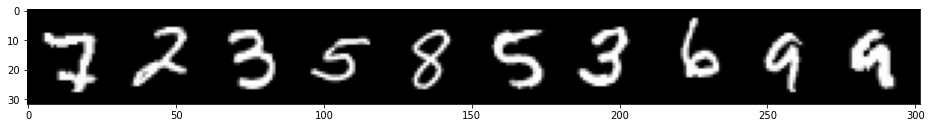

In [21]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # to widen the printed array

# Grab the first batch of images
for images,labels in train_loader: 
    break

# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(16,8))
# We need to transpose the images from CWH to WHC
# C - color chanel
# W - width
# H - height
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [22]:
labels

tensor([7, 2, 3, 5, 8, 5, 3, 6, 9, 9])

In [23]:
type(images)

torch.Tensor

## Define a convolutional model
In the previous section we used only fully connected layers, with an input layer of 784 (our flattened 28x28 images), hidden layers of 120 and 84 neurons, and an output size representing 10 possible digits.

This time we'll employ two convolutional layers and two pooling layers before feeding data through fully connected hidden layers to our output. The model follows CONV/RELU/POOL/CONV/RELU/POOL/FC/RELU/FC.

<div class="alert alert-info"><strong>Let's walk through the steps we're about to take.</strong><br>

1. Extend the base Module class:
   
<tt><font color=white>class ConvolutionalNetwork(nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()</font></tt><br>

2. Set up the convolutional layers with <a href='https://pytorch.org/docs/stable/nn.html#conv2d'><tt><strong>torch.nn.Conv2d()</strong></tt></a><br><br>The first layer has one input channel (the grayscale color channel). We'll assign 6 output channels for feature extraction. We'll set our kernel size to 3 to make a 3x3 filter, and set the step size to 1.<br>
<tt><font color=white>&nbsp;&nbsp;&nbsp;&nbsp;self.conv1 = nn.Conv2d(1, 6, 3, 1)</font></tt><br>
The second layer will take our 6 input channels and deliver 16 output channels.<br>
<tt><font color=white>&nbsp;&nbsp;&nbsp;&nbsp;self.conv2 = nn.Conv2d(6, 16, 3, 1)</font></tt><br><br>

3. Set up the fully connected layers with <a href='https://pytorch.org/docs/stable/nn.html#linear'><tt><strong>torch.nn.Linear()</strong></tt></a>.<br><br>The input size of (5x5x16) is determined by the effect of our kernels on the input image size. A 3x3 filter applied to a 28x28 image leaves a 1-pixel edge on all four sides. In one layer the size changes from 28x28 to 26x26. We could address this with zero-padding, but since an MNIST image is mostly black at the edges, we should be safe ignoring these pixels. We'll apply the kernel twice, and apply pooling layers twice, so our resulting output will be 
$\;(((28-2)/2)-2)/2 = 5.5\;$ which rounds down to 5 pixels per side.<br>
<tt><font color=white>&nbsp;&nbsp;&nbsp;&nbsp;self.fc1 = nn.Linear(5\*5\*16, 120)</font></tt><br>
<tt><font color=white>&nbsp;&nbsp;&nbsp;&nbsp;self.fc2 = nn.Linear(120, 84)</font></tt><br>
<tt><font color=white>&nbsp;&nbsp;&nbsp;&nbsp;self.fc3 = nn.Linear(84, 10)</font></tt><br>
See below for a more detailed look at this step.<br><br>

4. Define the forward method.<br><br>Activations can be applied to the convolutions in one line using <a href='https://pytorch.org/docs/stable/nn.html#id27'><tt><strong>F.relu()</strong></tt></a> and pooling is done using <a href='https://pytorch.org/docs/stable/nn.html#maxpool2d'><tt><strong>F.max_pool2d()</strong></tt></a><br>
<tt><font color=white>def forward(self, X):<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.relu(self.conv1(X))<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.max_pool2d(X, 2, 2)<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.relu(self.conv2(X))<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.max_pool2d(X, 2, 2)<br>
</font></tt>Flatten the data for the fully connected layers:<br><tt><font color=white>
&nbsp;&nbsp;&nbsp;&nbsp;X = X.view(-1, 5\*5\*16)<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.relu(self.fc1(X))<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = self.fc2(X)<br>
&nbsp;&nbsp;&nbsp;&nbsp;return F.log_softmax(X, dim=1)</font></tt>
</div>

<div class="alert alert-danger"><strong>Breaking down the convolutional layers</strong> (this code is for illustration purposes only.)</div>

In [24]:
# Define layers
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [25]:
# Grab the first MNIST record
for i, (X_train, y_train) in enumerate(train_data):
    break
    
X_train.shape    

torch.Size([1, 28, 28])

In [26]:
# Create a rank-4 tensor to be passed into the model
# (train_loader will have done this already)
x = X_train.view(1,1,28,28)
print(x.shape)

torch.Size([1, 1, 28, 28])


In [27]:
# Perform the first convolution/activation
x = F.relu(conv1(x))
print(x.shape)

torch.Size([1, 6, 26, 26])


In [28]:
# Run the first pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 6, 13, 13])


In [29]:
# Perform the second convolution/activation
x = F.relu(conv2(x))
print(x.shape)

torch.Size([1, 16, 11, 11])


In [30]:
# Run the second pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 16, 5, 5])


In [31]:
# Flatten the data
x = x.view(-1, 5*5*16)
print(x.shape)

torch.Size([1, 400])


<div class="alert alert-danger"><strong>This is how the convolution output is passed into the fully connected layers.</strong></div>

Now let's run the code.

In [32]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [33]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Including the bias terms for each layer, the total number of parameters being trained is:<br>

$\quad\begin{split}(1\times6\times3\times3)+6+(6\times16\times3\times3)+16+(400\times120)+120+(120\times84)+84+(84\times10)+10 &=\\
54+6+864+16+48000+120+10080+84+840+10 &= 60,074\end{split}$<br>

In [34]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [35]:
count_parameters(model)

    54
     6
   864
    16
 48000
   120
 10080
    84
   840
    10
______
 60074


In [36]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[[[ 0.2548,  0.2767, -0.0781],
          [ 0.3062, -0.0730,  0.0673],
          [-0.1623,  0.1958,  0.2938]]],


        [[[-0.2445,  0.2897,  0.0624],
          [ 0.2463,  0.0451,  0.1607],
          [-0.0471,  0.2570,  0.0493]]],


        [[[-0.1556,  0.0850, -0.1536],
          [-0.0391, -0.1354,  0.2211],
          [-0.2631, -0.1537, -0.0941]]],


        [[[-0.2004,  0.0315, -0.3292],
          [ 0.3010, -0.2832,  0.2573],
          [ 0.0555, -0.1082,  0.2060]]],


        [[[ 0.0520,  0.2693,  0.0364],
          [-0.1051,  0.0896, -0.0904],
          [ 0.1403,  0.2976,  0.1927]]],


        [[[-0.1457,  0.1924,  0.0596],
          [ 0.1693, -0.2032, -0.3300],
          [-0.1288, -0.2557,  0.2735]]]], requires_grad=True)
Parameter containing:
tensor([ 0.0960,  0.1381,  0.1054, -0.0058,  0.2609, -0.2368],
       requires_grad=True)
Parameter containing:
tensor([[[[ 0.0086, -0.0929,  0.0420],
          [-0.0469,  0.0417, -0.0284],
          [ 0.1129, -

## Define loss function & optimizer

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train the model
This time we'll feed the data directly into the model without flattening it first.

In [38]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss.item())
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  600 [  6000/60000]  loss: 0.04055623  accuracy:  78.417%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.08253475  accuracy:  85.800%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.36422682  accuracy:  88.689%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.01856371  accuracy:  90.537%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.00725011  accuracy:  91.680%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.00283015  accuracy:  92.519%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.60603589  accuracy:  93.176%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.02749655  accuracy:  93.650%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.00948194  accuracy:  94.059%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.03380714  accuracy:  94.368%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.01744066  accuracy:  97.800%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.08224805  accuracy:  97.858%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.00148837  accuracy:  97.922%
epoch:  1  b

## Plot the loss and accuracy comparisons

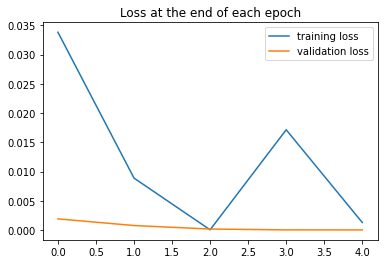

In [39]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [40]:
test_losses

[0.001936012296937406,
 0.0008001286769285798,
 0.0001972642494365573,
 5.5666721891611814e-05,
 4.9226782721234486e-05]

While there may be some overfitting of the training data, there is far less than we saw with the ANN model.

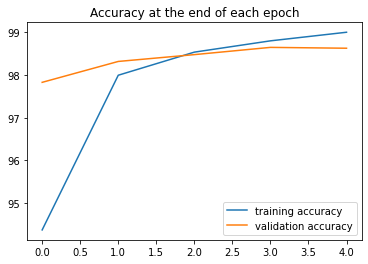

In [41]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [42]:
train_correct[0]

tensor(56621)

In [43]:
len(train_loader)

6000

In [44]:
temp = 100*train_correct[0]/(len(train_loader)*10)
temp.numpy() # converts tensor to numpy array

array(94.36833, dtype=float32)

## Evaluate Test Data

In [45]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [46]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9863/10000 =  98.630%


## Display the confusion matrix

In [47]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 972    0    1    0    0    2    6    0    4    0]
 [   0 1134    1    0    1    0    4    5    1    3]
 [   4    0 1013    1    1    0    1    3    1    1]
 [   0    0    2 1006    0   14    0    0    1    2]
 [   0    0    1    0  973    0    1    0    1    8]
 [   0    0    0    2    0  870    4    0    1    4]
 [   2    0    0    0    3    2  941    0    0    0]
 [   1    1   13    0    0    1    0 1017    2    9]
 [   0    0    1    1    0    1    1    1  961    6]
 [   1    0    0    0    4    2    0    2    2  976]]


## Examine the misses
We can track the index positions of "missed" predictions, and extract the corresponding image and label. We'll do this in batches to save screen space.

In [48]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

137

In [49]:
# Display the first 10 index positions
misses[:10]

array([ 247,  320,  321,  340,  445,  471,  495,  582,  583,  659])

In [50]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

In [51]:
row

Now that everything is set up, run and re-run the cell below to view all of the missed predictions.<br>
Use <kbd>Ctrl+Enter</kbd> to remain on the cell between runs. You'll see a <tt>StopIteration</tt> once all the misses have been seen.

Index: [ 247  320  321  340  445  471  495  582  583  659  720  882]
Label: [   4    9    2    5    6    9    8    8    2    2    5    9]
Guess: [   2    8    7    3    0    7    0    2    7    7    8    7]


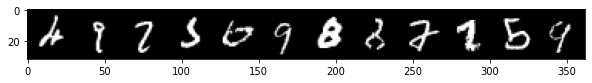

In [52]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Run a new image through the model
We can also pass a single image through the model to obtain a prediction.
Pick a number from 0 to 9999, assign it to "x", and we'll use that value to select a number from the MNIST test set.

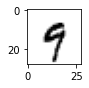

In [53]:
x = 2019
plt.figure(figsize=(1,1))
plt.imshow(test_data[x][0].reshape((28,28)), cmap="gist_yarg");

In [54]:
model.eval()
with torch.no_grad():
    new_pred = model(test_data[x][0].view(1,1,28,28)).argmax()
print("Predicted value:",new_pred.item())
# model.eval() vs torch.no_grad()
# https://discuss.pytorch.org/t/model-eval-vs-with-torch-no-grad/19615

Predicted value: 9


## save model

In [55]:
torch.save(model.state_dict(), 'MNIST-CNN-Model.pt')

In [56]:
model2 = ConvolutionalNetwork()
model2.load_state_dict(torch.load('MNIST-CNN-Model.pt'))
model2.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# CIFAR Code Along with CNN

The <a href='https://en.wikipedia.org/wiki/CIFAR-10'>CIFAR-10</a> dataset is similar to MNIST, except that instead of one color channel (grayscale) there are three channels (RGB).<br>
Where an MNIST image has a size of (1,28,28), CIFAR images are (3,32,32). There are 10 categories an image may fall under:
0. airplane
1. automobile
2. bird
3. cat
4. deer
5. dog
6. frog
7. horse
8. ship
9. truck

## Perform standard imports

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## Load the CIFAR-10 dataset
PyTorch makes the CIFAR-10 train and test datasets available through <a href='https://pytorch.org/docs/stable/torchvision/index.html'><tt><strong>torchvision</strong></tt></a>. The first time they're called, the datasets will be downloaded onto your computer to the path specified. From that point, torchvision will always look for a local copy before attempting another download.<br>The set contains 50,000 train and 10,000 test images.

Refer to the previous section for explanations of transformations, batch sizes and <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'><tt><strong>DataLoader</strong></tt></a>.

In [58]:
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='../Data', train=False, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../Data/cifar-10-python.tar.gz to ../Data
Files already downloaded and verified


In [59]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [60]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

### Create loaders

In [61]:
torch.manual_seed(101)  # for reproducible results

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

### Define strings for labels
We can call the labels whatever we want, so long as they appear in the order of 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'. Here we're using 5-character labels padded with spaces so that our reports line up later.

In [62]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

We don't want to use the variable name "class" here, as it would overwrite Python's built-in keyword.

## View a batch of images

Label: [    1     5     8     1     6     1     6     3     7     9]
Class:    car   dog  ship   car  frog   car  frog   cat horse truck


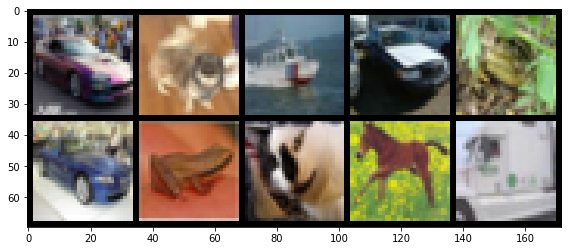

In [63]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Define the model

The only changes are:
* take in 3-channel images instead of 1-channel
* adjust the size of the fully connected input<br>

Our first convolutional layer will have 3 input channels, 6 output channels, a kernel size of 3 (resulting in a 3x3 filter), and a stride length of 1 pixel.<br>These are passed in as <tt>nn.Conv2d(3,6,3,1)</tt>

So how does a CNN layer actually _'works'_?  

![CNN Scan](https://drive.google.com/uc?id=1JictobCPmaIX_9pm2mQewc4QiAzl0pzO "Remember Billie Eilish above?")  

<br/>A colored image has 3 channels,  
![RGB Image](https://drive.google.com/uc?id=1QlU04TZ6IN2IRqQJFB8m6GFJ2MmqYGhz "https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53")  

<br/>A 3-channel convolution,  
![RGB Convolution](https://drive.google.com/uc?id=1CGIqxGHjJGXr8aduPtwGd1-ikgA3WqJ5 "https://towardsdatascience.com/a-comprehensive-introduction-to-different-types-of-convolutions-in-deep-learning-669281e58215")  

![RGB Convolution Summation](https://drive.google.com/uc?id=1fpM3NLvyjeiKF6_at0Nv4XhYPRkwH1IY "https://towardsdatascience.com/a-comprehensive-introduction-to-different-types-of-convolutions-in-deep-learning-669281e58215")

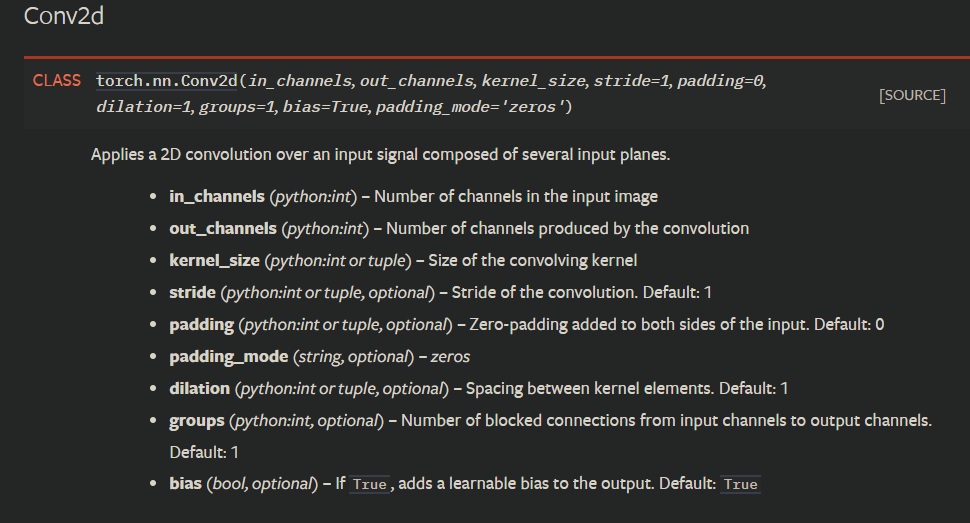

In [64]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)  # changed from (1, 6, 5, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(6*6*16, 120)   # changed from (4*4*16) to fit 32x32 images with 3x3 filters
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

<div class="alert alert-info"><strong>Why <tt>(6x6x16)</tt> instead of <tt>(5x5x16)</tt>?</strong><br>
With MNIST the kernels and pooling layers resulted in $\;(((28−2)/2)−2)/2=5.5 \;$ which rounds down to 5 pixels per side.<br>
With CIFAR the result is $\;(((32-2)/2)-2)/2 = 6.5\;$ which rounds down to 6 pixels per side.</div>

In [65]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Including the bias terms for each layer, the total number of parameters being trained is:<br>

$\quad\begin{split}(3\times6\times3\times3)+6+(6\times16\times3\times3)+16+(576\times120)+120+(120\times84)+84+(84\times10)+10 &=\\
162+6+864+16+69120+120+10080+84+840+10 &= 81,302\end{split}$<br>

In [66]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [67]:
count_parameters(model)

   162
     6
   864
    16
 69120
   120
 10080
    84
   840
    10
______
 81302


## Define loss function & optimizer

In [68]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train the model

In [69]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss.item())
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.74091792  accuracy:  24.370%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 2.28505325  accuracy:  30.680%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.41110420  accuracy:  34.463%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.77556062  accuracy:  37.425%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 0.87544328  accuracy:  39.820%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.40881562  accuracy:  50.940%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.13322639  accuracy:  51.780%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 1.45552599  accuracy:  52.453%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 1.10780263  accuracy:  52.767%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 1.01513064  accuracy:  53.120%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 1.21744430  accuracy:  56.320%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 0.94388628  accuracy:  56.850%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 1.29108834  accuracy:  56.983%
epoch:  2  b

## Plot the loss and accuracy comparisons

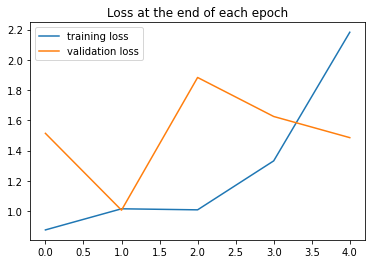

In [70]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

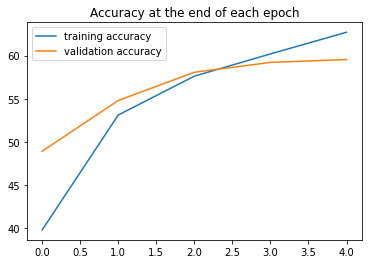

In [71]:
plt.plot([t/500 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Evaluate Test Data

In [72]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(4893), tensor(5480), tensor(5807), tensor(5921), tensor(5954)]

Test accuracy: 59.540%


## Display the confusion matrix
In order to map predictions against ground truth, we need to run the entire test set through the model.<br>
Also, since our model was not as accurate as with MNIST, we'll use a <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>heatmap</a> to better display the results.

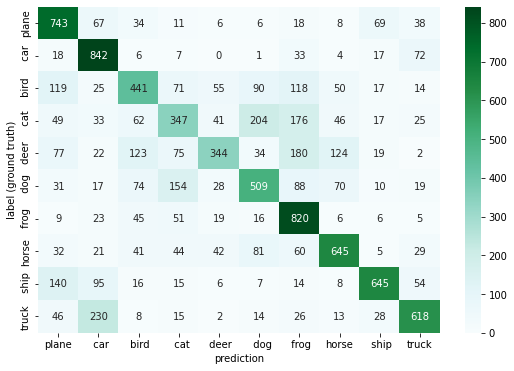

In [73]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

For more info on the above chart, visit the docs on <a href='https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html'>scikit-learn's confusion_matrix</a>, <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps</a>, and <a href='https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html'>matplotlib colormaps</a>. 